In [1]:
import torch
import torch.nn as nn
import timm
from d2l import torch as d2l
from torch.utils.data import DataLoader
import torchvision
import os

D:\Ananconda\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] 找不到指定的模块。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='/Datasets/FashionMNIST',
                                                train=True,download=True,transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='/Datasets/FashionMNIST',
                                               train=False,download=True,transform=torchvision.transforms.ToTensor())

In [3]:
#def get_fashion_mnist_labels(labels):
#    text_labels=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
#    return [text_labels[int(i)] for i in labels]

In [4]:
batchsize = 64   #每次抓取的数据数量
train_iter = DataLoader(mnist_train, batch_size=batchsize, shuffle=True, num_workers=0)
test_iter = DataLoader(mnist_test, batch_size=batchsize, shuffle=False, num_workers=0)

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
# 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
# BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [6]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
# 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

In [7]:
'''import torch.nn.functional as F
import numpy as np

# define structure
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes)
        )

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        # print(out.shape)
        # print(self.shortcut(x).shape)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)               # the first layer

        self.layer1 = self._make_layer(block, 64, num_block[0], stride=1)             # four layers 2-5
        self.layer2 = self._make_layer(block, 128, num_block[1], stride=2)            # four layers 6-9
        self.layer3 = self._make_layer(block, 256, num_block[2], stride=2)            # four layers 10-13
        self.layer4 = self._make_layer(block, 512, num_block[3], stride=2)            # four layers 14-17

        self.fc = nn.Linear(512, num_classes)                                         # the last layer

    def _make_layer(self, block, planes, num_blocks, stride):                          
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.in_planes, planes, stride))
            else:
                layers.append(block(planes, planes, 1))

        self.in_planes = planes   
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out'''

'import torch.nn.functional as F\nimport numpy as np\n\n# define structure\nclass BasicBlock(nn.Module):\n    def __init__(self, in_planes, planes, stride=1):\n        super(BasicBlock, self).__init__()\n        self.conv1 = nn.Sequential(\n            nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=stride, padding=1, bias=False),\n            nn.BatchNorm2d(planes),\n            nn.ReLU()\n        )\n\n        self.conv2 = nn.Sequential(\n            nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.BatchNorm2d(planes)\n        )\n\n        if stride != 1 or in_planes != planes:\n            self.shortcut = nn.Sequential(\n                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride),\n                nn.BatchNorm2d(planes)\n            )\n        else:\n            self.shortcut = nn.Sequential()\n\n    def forward(self, x):\n        out = self.conv1(x)\n        out = self.conv2

loss 0.061, train acc 0.979, test acc 0.894
1809.6 examples/sec on cuda:0


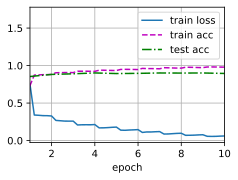

In [9]:
#net = ResNet(BasicBlock,[256,1,28,28],10)
net = timm.create_model('resnet18', pretrained=True)
net.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(2,2),bias=True)
net.fc =  nn.Linear(net.fc.in_features, 10)
#种类10
lr, num_epochs, batch_size = 0.003, 10, 64
train(net,train_iter, test_iter, num_epochs, lr, d2l.try_gpu())